In [606]:
import numpy as np
import stat as st
import pandas as pd
import matplotlib.pyplot as plt
import sys
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
import matplotlib.pyplot as plt
import math

Функции

In [52]:
df = pd.read_csv('2_goda.csv', sep=';', keep_default_na=False)
data = df.cost

In [617]:
def stat(x):
    _x = x  # Для возможности предобработки данных (например, исключения нечисловых значений) 
    print('счет', len(x))
    print('среднее', (np.mean(_x)))
    print('минимальное', np.min(_x), 'и максимальное', np.max(_x))
    print('стандартное отклонение', np.std(_x))
    print('дисперсия', np.var(_x))
    print('коэффициент вариации', (np.mean(_x)) / (np.std(_x)))
    print('коэффициент асимметрии', scs.skew(_x))  # асимметрия 
    print('эксцесс', scs.kurtosis(_x)) # эксцесс
    _range = np.linspace(0.9 * np.min(_x), 1.1 * np.max(_x), 12)
    print('квантили 25%, 50%, 75%', np.percentile(_x, 25), np.percentile(_x, 50), np.percentile(_x, 75))
    print('оценка плотности распределения:')
    plotnost = scs.gaussian_kde(_x)(_range)
    print(plotnost) # оценка плотности распределения


def plotMovingAverage(series, n):
    rolling_mean = series.rolling(window=n).mean()#параметры скользящего среднего

    plt.figure(figsize=(15,5))#размер
    plt.title("Moving average\n window size = {}".format(n))#заголовок
    plt.plot(rolling_mean, "r-", label="Rolling mean trend")#скол. среднее, цвет, подпись линии

    plt.plot(df.cost[n:], "k", label="Actual values")#значения [n:],начиная с н до конца
    plt.legend(loc="upper left")#где расположить легенду, тут сверху слева
    plt.grid(True)#сетка на графике


def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)

        print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(y)[1])

        plt.tight_layout()
    return


def autocor(y, lags=None, figsize=(12, 7), style='bmh'):
    
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)#размер
        layout = (2, 1)
        acf_ax = plt.subplot2grid(layout, (1, 0))

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)

        print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(y)[1])

        plt.tight_layout()
    return


def test_t_and_wilc(data):
    group1 = data[:int((len(data)//2))]
    group2 = data[int(len(data)//2):]
    # Критерий Стьюдента для двух выборок
    # Нулевая гипотеза: мат ожидания для двух групп равны
    # Причём должно выполнится предположение о равной дисперсии
    # (способы проверки которого приведены ниже)
    # Это верно для независимых групп: например, результаты экзамена для мальчиков и девочек
    # И для зависимых групп: например, как один и тот же класс сдал 2 разных экзамена.
    t_statistic, p_value = scs.ttest_ind(group1, group2)
 
    # p_value &lt; 0.05 =&gt; альтернативная гипотеза:
    # с 5% вероятностью ошибки первого рода у нас будет разное мат. ожидание
    # тест с 2 хвостами, двухпарный
    print("two-sample t-test:")
    print('p_value =', p_value)
    print('t_statistic =', t_statistic)
 
    # Если данные не распределены нормально, применяем критерий Манна-Уитни, также известный как 
    # Критерий Уилкоксона для двух выборок
    u, p_value = scs.mannwhitneyu(group1, group2, alternative='two-sided')
    g1 = len(group1)
    g2 = len(group2)
    print('two-sample wilcoxon-test(mann-whitneyu), p_value =', p_value)
    print('U =', u)
    print('M(U) =', g1 * g2 / 2)
    print('D(U) =', g1 * g2 * (g1 + g2 + 1) / 12)
    if (u - (g1 * g2 / 2)) / math.sqrt(g1 * g2 * (g1 + g2 + 1) / 12) > 0:
        z = (u - (g1 * g2 / 2) - 0.5) / math.sqrt(g1 * g2 * (g1 + g2 + 1) / 12)
    else:
        z = (u - (g1 * g2 / 2) + 0.5) / math.sqrt(g1 * g2 * (g1 + g2 + 1) / 12)
    print('Z =', z)


def test_ks(data):
    group1 = data[:int(len(data)//2)]
    group2 = data[int(len(data)//2):]
    
    ks_statistic, p_value = scs.ks_2samp(group1, group2)
    print('two-sample ks-test')
    print('p_value =', p_value)
    print('ks_statistic =', ks_statistic)


def normal(x):
    print('normaltest teststat = %f p_value = %f' % scs.normaltest(x))


def fisher(data):
    group1 = data[:int((len(data)//2))]
    group2 = data[int(len(data)//2):]
    if np.var(group1) >= np.var(group2):
        f = np.var(group1) / np.var(group2)
    else:
        f = np.var(group2) / np.var(group1)
    print('критерий Фишера', f)

Решение

In [615]:
stat(data)

счет 732
среднее 2489.84895492
минимальное 2212.29 и максимальное 3011.6
стандартное отклонение 184.045018631
дисперсия 33872.5688827
дисперсия 33872.5688827
коэффициент вариации 13.5284778335
коэффициент асимметрии 0.6407256806650948
эксцесс -0.6760643634973542
квантили 25%, 50%, 75% 2337.89 2430.99 2651.47
оценка плотности распределения:
[  3.41910012e-09   1.79937689e-05   9.96918989e-04   2.56321253e-03
   1.76620296e-03   8.57818155e-04   1.31531137e-03   5.58898064e-04
   1.59448649e-04   1.98743738e-05   3.03769436e-08   1.75245162e-13]


In [502]:
data.describe()

count     732.000000
mean     2489.848955
std       184.170861
min      2212.290000
25%      2337.890000
50%      2430.990000
75%      2651.470000
max      3011.600000
Name: cost, dtype: float64

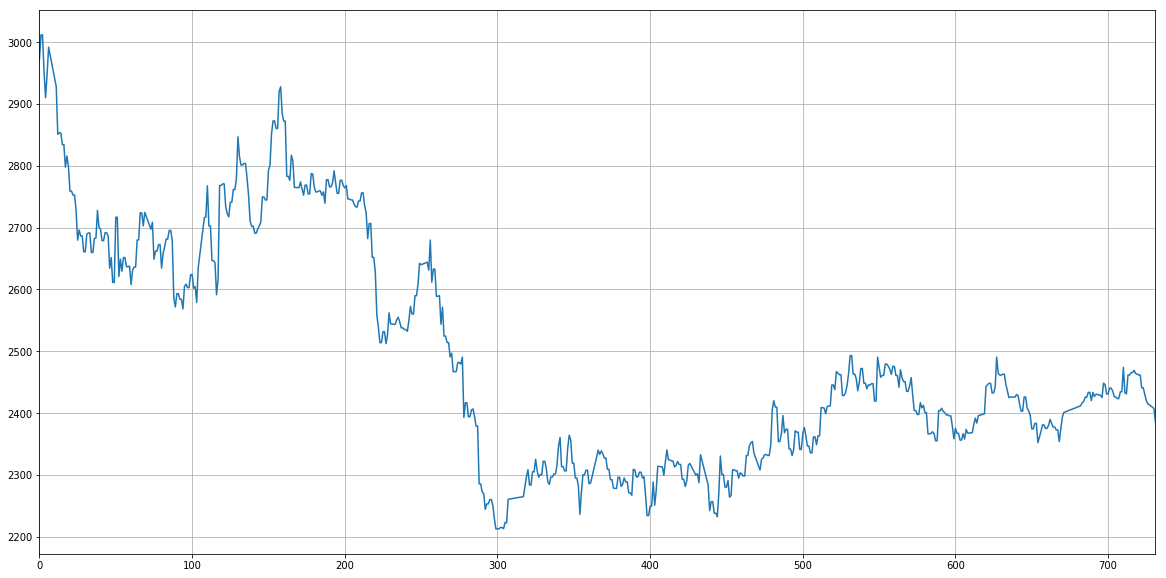

In [581]:
data.plot(figsize=(20, 10), grid=True)
plt.show()

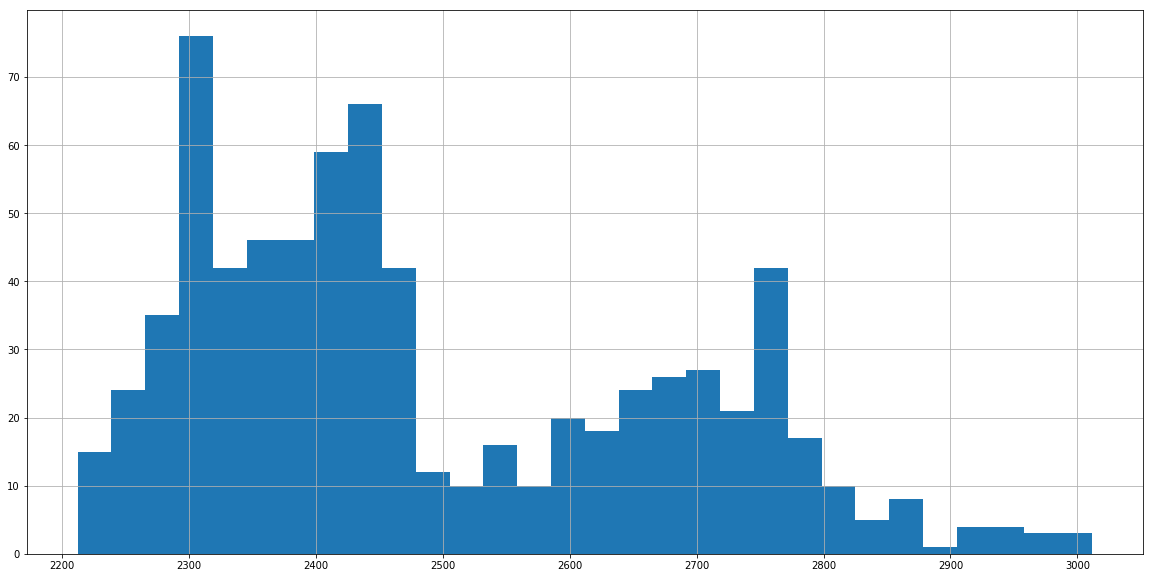

In [588]:
data.hist(figsize=(20, 10),bins=30)
plt.show()

In [595]:
data.density()
plt.show()

AttributeError: 'Series' object has no attribute 'density'

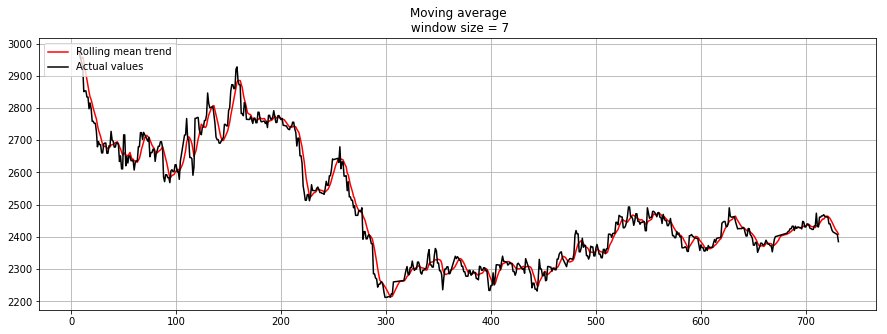

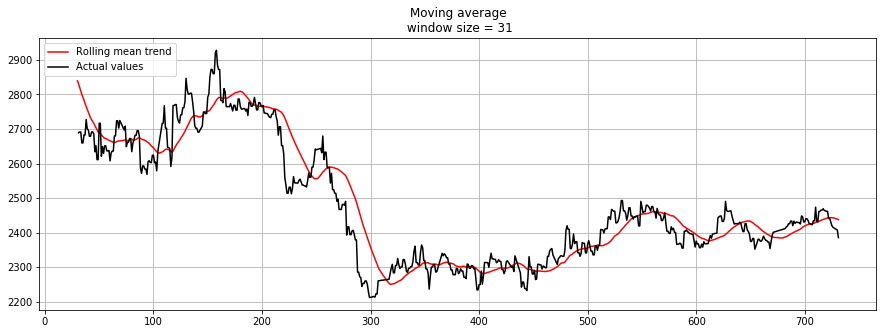

In [505]:
plotMovingAverage(data, 7)#скользяшее среднее по неделе
plotMovingAverage(data, 31)#скользяшее среднее по месяцу
plt.show()

Критерий Дики-Фуллера: p=0.057614


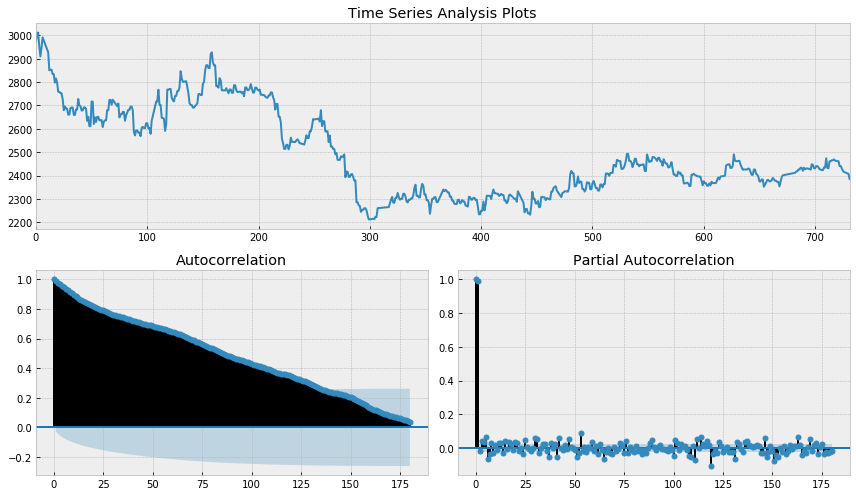

In [506]:
tsplot(data, lags=180)
plt.show()

Критерий Дики-Фуллера: p=0.000000


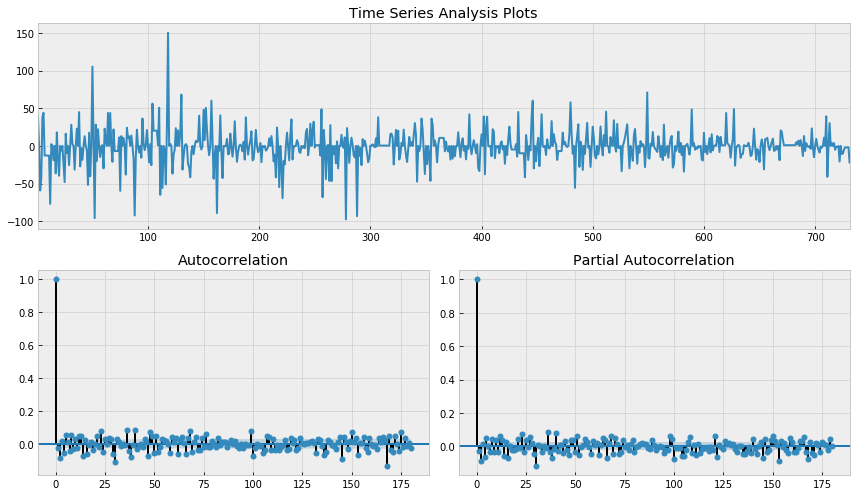

In [546]:
#первые разности
dataR1 = data - data.shift(1)
tsplot(dataR1[1:], lags=180)
plt.show()

In [620]:
fisher(dataR1[1:])

критерий Фишера 2.70734865995


In [523]:
stat(dataR1[1:])

счет 731
среднее -0.802216142271
минимальное и максимальное -97.64 150.47
стандартное отклонение 21.2688575264
коэффициент вариации -0.0377178765374
коэффициент асимметрии 0.10541082893509636
эксцесс 7.066232971450104
квантили 25%, 50%, 75% -8.285 0.0 5.245
оценка плотности распределения:
[  2.94254483e-04   4.69569952e-04   1.94619711e-03   8.86157583e-03
   2.82152002e-02   4.40842545e-03   1.31378580e-03   1.68055829e-04
   2.67154254e-05   4.78752833e-06   3.58080937e-05   2.91206666e-06]


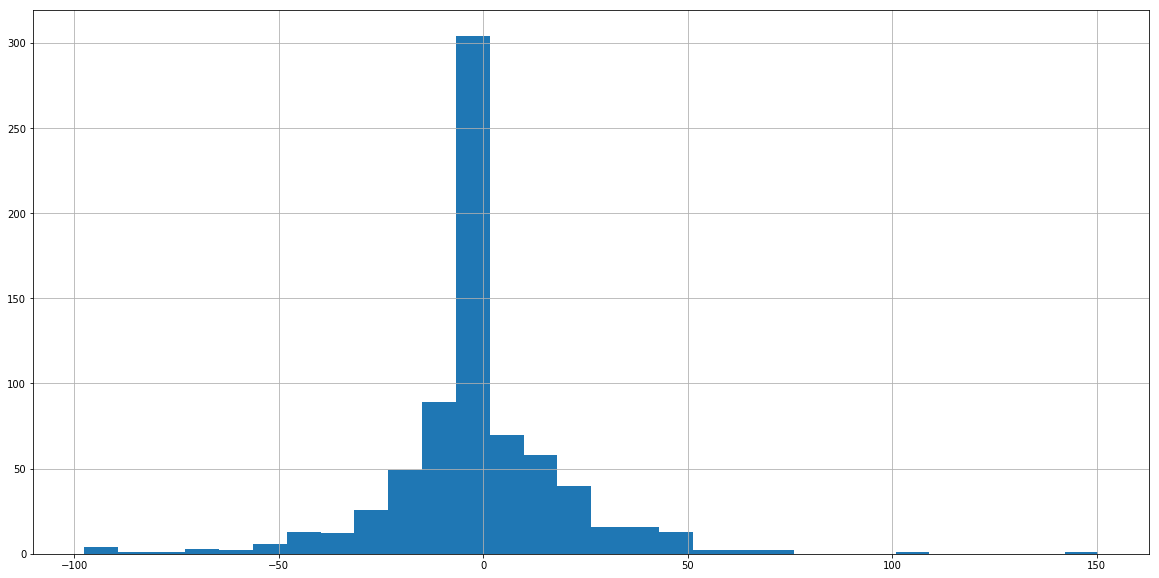

In [589]:
dataR1.hist(figsize=(20,10), bins=30)
plt.show()

Критерий Дики-Фуллера: p=0.000000


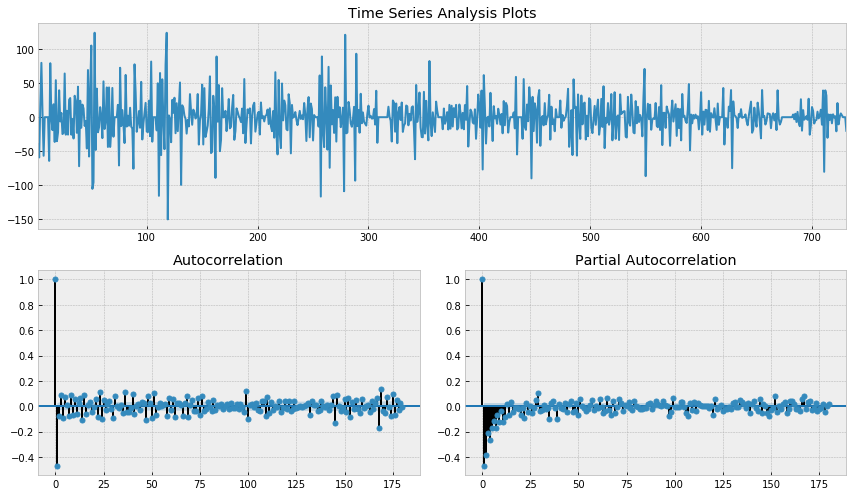

In [570]:
#вторые разности
dataR2 = dataR1 - dataR1.shift(1)
tsplot(dataR2[2:], lags=180)
plt.show()

In [623]:
fisher(dataR2[2:])

критерий Фишера 2.67719861581


In [510]:
stat(dataR2[2:])

счет 730
среднее -0.0845342465753
минимальное и максимальное -150.47 124.38
стандартное отклонение 30.4711195947
коэффициент вариации -0.00277424156709
коэффициент асимметрии -0.08533327297318549
эксцесс 3.1242267900062446
квантили 25%, 50%, 75% -14.7475 0.0 14.2175
оценка плотности распределения:
[  2.14364614e-05   2.79208241e-04   4.90614244e-04   1.01516985e-03
   4.58336400e-03   1.41455526e-02   1.30243975e-02   4.06091664e-03
   1.26053029e-03   5.05013101e-04   1.34686661e-04   5.27892785e-05]


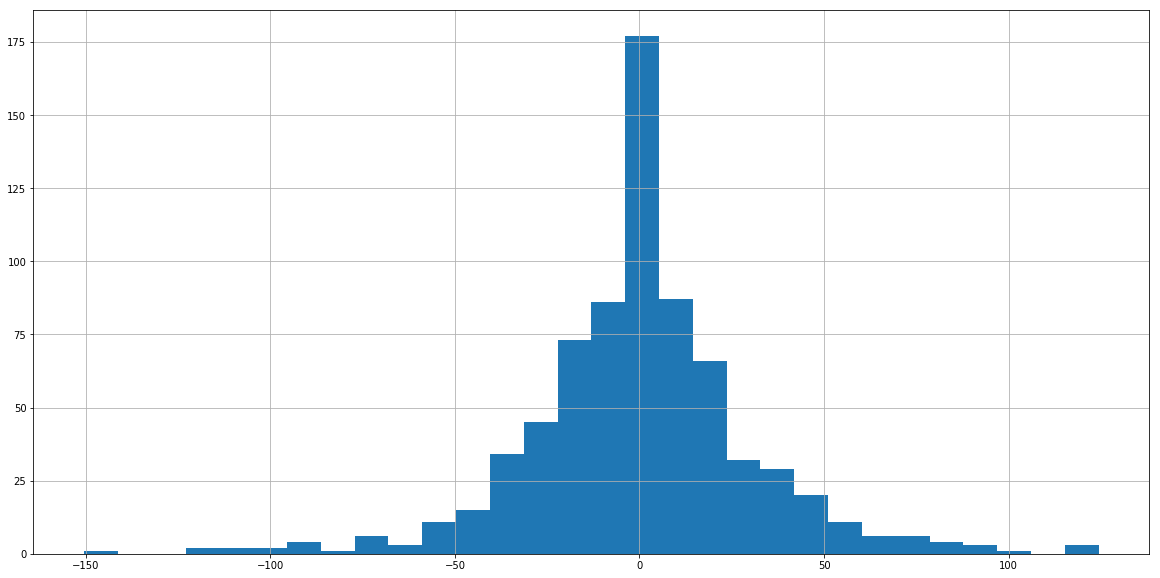

In [593]:
dataR2.hist(figsize=(20,10), bins=30)
plt.show()

Критерий Дики-Фуллера: p=0.057614


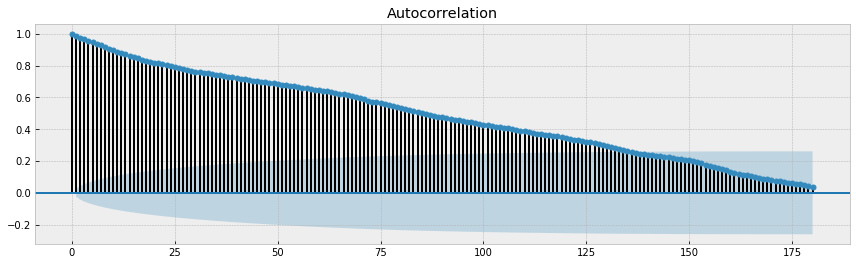

In [511]:
#автокорреляция ряда
autocor(data, lags=180)
plt.show()

Критерий Дики-Фуллера: p=0.000000


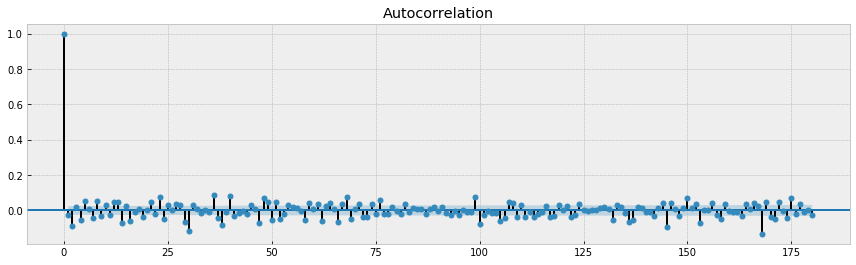

In [512]:
#перые разности автокорреляция
autocor(dataR1[1:], lags=180)
plt.show()

Критерий Дики-Фуллера: p=0.000000


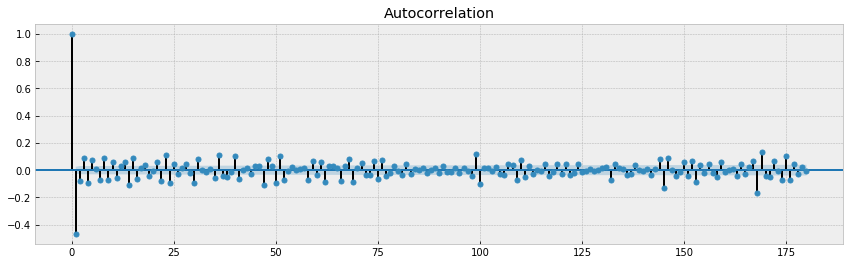

In [513]:
#вторые разности автокорреляция
autocor(dataR2[2:], lags=180)
plt.show()

In [626]:
#Т-тест и тест манна уитни
test_t_and_wilc(dataR2[2:])

two-sample t-test:
p_value = 0.996522861091
t_statistic = 0.00435945798326
two-sample wilcoxon-test(mann-whitneyu), p_value = 0.612725458546
U = 65170.0
M(U) = 66612.5
D(U) = 8115622.916666667
Z = -0.506179241241


In [592]:
#тест Колмогорова-Смирнова
test_ks(dataR1[1:])

two-sample ks-test
p_value = 0.0632545897583
ks_statistic = 0.0962946328318


In [575]:
#тест нормальности распределения
normal(data)

normaltest teststat = 75.808153 p_value = 0.000000
